In [1]:
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer
from util import *
from onehot import LabelBinarizerEx
from pipeline import FeaturePipeline, DataFramePipeline
from binning import Binner
from ensemble import EnsembleStackClassifierEx, StackRegressor
from addcols import AddColumns
from impute import GroupImputer
from ordinal import Ordinar

%matplotlib inline
from matplotlib import pyplot

C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## explore data

In [2]:
import pandas as pd
house_train=pd.read_csv('train.csv')
target_col='SalePrice'
id_col='Id'
target=house_train[target_col]#/house_train['LotArea']
houses=house_train.copy()

In [3]:
num_summary=houses.describe()
num_summary

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
cat_summary=houses.describe(include=['O'])
cat_summary

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


add unit price

In [5]:
houses['UnitPrice']=houses[target_col]/houses['LotArea']

explore features

In [6]:
corrs=houses.corr()
corrs[['SalePrice','UnitPrice']].sort_values(['UnitPrice'],ascending=False)

,SalePrice,UnitPrice
UnitPrice,0.273401,1.000000
MSSubClass,-0.084284,0.527542
YearBuilt,0.522897,0.392159
OverallQual,0.790982,0.377578
GarageYrBlt,0.486362,0.372916
YearRemodAdd,0.507101,0.348566
SalePrice,1.000000,0.273401
FullBath,0.560664,0.244024
GarageCars,0.640409,0.206168
MasVnrArea,0.477493,0.201573


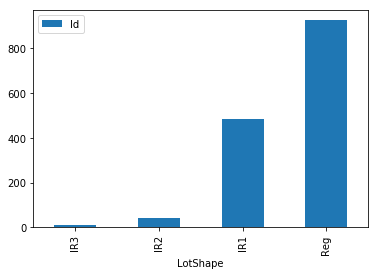

In [7]:
df=houses.groupby('LotShape').count()[[id_col]].sort_values(id_col)
df.plot(kind='bar')

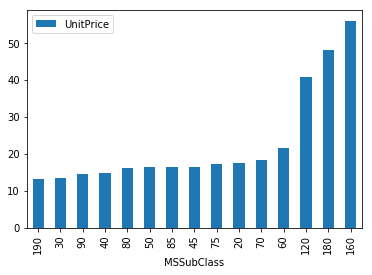

In [8]:
df=houses.groupby('MSSubClass').mean()[['UnitPrice']].sort_values('UnitPrice')
df.plot(kind='bar')

LotShape is ordinal

'Reg' is max

In [9]:
# corrs['UnitPrice']['LotFrontage']

LotFrontage is slight neg corr with up

it should be discretized

In [10]:
# corrs['UnitPrice']['LotArea']

same with LotFrontage

In [11]:
# df=house_train.groupby('Utilities').mean()[['UnitPrice']]
# df.sort_values('UnitPrice').plot(kind='bar')

make Utilities ordinal

In [12]:
# df=house_train.groupby('LandSlope').mean()[['UnitPrice']]
# df.sort_values('UnitPrice').plot(kind='bar')

make LandSlope ordinal

merge condition1&2 into 1 col

In [13]:
# df=house_train.groupby('HouseStyle').mean()[['UnitPrice']].sort_values('UnitPrice')
# df.plot(kind='bar')

make HouseStyle ordinal , SLvl is max

In [14]:
# corrs['UnitPrice']['YearRemodAdd']

discretize YearBuilt, band is 9

In [15]:
# house_train['YearTotal']=house_train['YearRemodAdd']+house_train['YearBuilt']
# house_train['YearTotalBand']=pd.qcut(house_train['YearTotal'],6,labels=False,duplicates='drop')
# corrs=house_train.corr()
# corrs['UnitPrice'][['YearBuilt','YearBand','YearTotal','YearRemodAdd','YearTotalBand']]

add YearBuilt & YearRemodAdd to make YearTotal, discretize it

make ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish, GarageQual, GarageCond, PoolQC, Fence, ordinal

In [16]:
# df=house_train.groupby('RoofStyle').mean()[['UnitPrice']].sort_values('UnitPrice')
# df.plot(kind='bar')

In [17]:
import pandas as pd
import numpy as np
import math
from sys import float_info

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error,mean_squared_error

class Binner(BaseEstimator,TransformerMixin):
    '''
    binner for continuous feature
    '''
    def __init__(self,strategy=None):
        self.strategy=strategy
        
    def fit(self, X, y=None):
        if self.strategy is None and y is not None:
            min_err=float_info.max
            best_q=0
            for q in range(2,10):
                s=pd.qcut(X,q,labels=False,duplicates='drop')
                err=mean_absolute_error(s,y)
                print(err)
                if err < min_err:
                    best_q=q
                    min_err=err
            print('best q: %d'% q)
        return self
    
b=Binner()
b.fit(houses['YearBuilt'],houses[target_col])

180920.70274
180920.207534
180919.717123
180919.215068
180918.738356
180918.265753
180917.743836
180917.243836
best q: 9


Binner(strategy=None)

In [18]:
houses.describe()[['MasVnrArea']]

,MasVnrArea
count,1452.000000
mean,103.685262
std,181.066207
min,0.000000
25%,0.000000
50%,0.000000
75%,166.000000
max,1600.000000


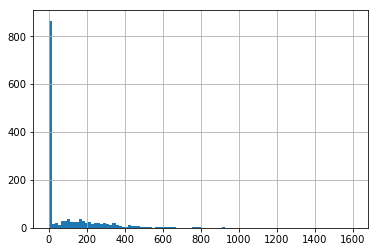

In [19]:
houses['MasVnrArea'].hist(bins=100)

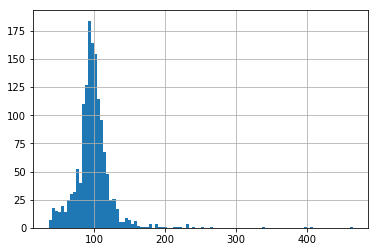

In [20]:
houses['LotArea_sqrt']=np.sqrt(houses['LotArea'])
houses['LotArea_sqrt'].hist(bins=100)

## feature enginering

In [21]:
drop_cols=[id_col,target_col]

In [22]:
num_cols=list(num_summary.columns)
num_cols=list(filter(lambda c: c not in drop_cols, num_cols))
# num_cols.remove('MSSubClass')

In [23]:
num_cont_cols=list(filter(lambda c: len(house_train[c].unique())>20 , num_cols))
num_disc_cols=set(num_cols)-set(num_cont_cols)
print(len(num_disc_cols),len(num_cont_cols))

16 20


In [24]:
cat_cols=list(cat_summary.columns)
# cat_cols.append('MSSubClass')

In [25]:
cat_ordinals={
    'LotShape':['IR3','IR2','IR1','Reg'],
    'Utilities':['ELO','NoSeWa','NoSewr','AllPub'],
    'LandSlope':['Sev','Mod','Gtl',],
    'HouseStyle':['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],
    'ExterQual':['po','fa','ta','gd','ex'],
    'BsmtQual':['po','fa','ta','gd','ex'],
    'BsmtCond':['po','fa','ta','gd','ex'],
    'BsmtExposure':['no','mn','av','gd'],
    'BsmtFinType1':['unf','lwq','rec','blq','alq','glq'],
    'BsmtFinType2':['unf','lwq','rec','blq','alq','glq'],
    'HeatingQC':['po','fa','ta','gd','ex'],
    'KitchenQual':['po','fa','ta','gd','ex'],
    'Functional':['sal','sev','maj2','maj1','mod','min2','min1','typ'],
    'FireplaceQu':['po','fa','ta','gd','ex'],
    'GarageFinish':['unf','rfn','fin'], 
    'GarageQual':['po','fa','ta','gd','ex'],
    'GarageCond':['po','fa','ta','gd','ex'], 
    'PoolQC':['fa','ta','gd','ex'], 
    'Fence':['mnww','gdwo','mnprv','gdprv']
}
cat_ord_cols=cat_ordinals.keys()

In [26]:
cat_nom_cols=set(cat_cols)-cat_ord_cols
print(len(cat_ord_cols),len(cat_nom_cols))

19 24


In [27]:
num_pipelines=[FeaturePipeline(c,c,Pipeline([('impute',Imputer(strategy='median'))])) 
               for c in num_cols]
cat_nom_pipelines=[FeaturePipeline(c,'',Pipeline([('onehot',LabelBinarizerEx([c]))])) for c in cat_nom_cols]
cat_ord_pipelines=[FeaturePipeline(c,c,Pipeline([('ordinal',Ordinar(cat_ordinals[c]))])) 
                       for c in cat_ord_cols]
full_pipeline=DataFramePipeline(num_pipelines+cat_nom_pipelines+cat_ord_pipelines)
prepared_house_train=full_pipeline.fit_transform(house_train)
prepared_house_train.drop(drop_cols+list(cat_nom_cols),axis=1,inplace=True)
prepared_house_train.head()

,MSSubClass,LotFrontage,LotArea,LotShape,Utilities,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,...,Condition1_RRNe,Condition1_RRNn,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
0,60.0,65.0,8450.0,3.0,3.0,2.0,3.0,7.0,5.0,2003.0,...,0,0,0,1,0,0,0,0,0,0
1,20.0,80.0,9600.0,3.0,3.0,2.0,0.0,6.0,8.0,1976.0,...,0,0,0,1,0,0,0,0,0,0
2,60.0,68.0,11250.0,2.0,3.0,2.0,3.0,7.0,5.0,2001.0,...,0,0,0,1,0,0,0,0,0,0
3,70.0,60.0,9550.0,2.0,3.0,2.0,3.0,7.0,5.0,1915.0,...,0,0,0,1,0,0,0,0,0,0
4,60.0,84.0,14260.0,2.0,3.0,2.0,3.0,8.0,5.0,2000.0,...,0,0,0,1,0,0,0,0,0,0


## train

In [39]:
from sklearn.linear_model import SGDClassifier,LinearRegression,ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor

base_regs=[
    ElasticNet(random_state=0),
#     LinearRegression(n_jobs=-1),
#     SVC(probability=True),
    RandomForestRegressor(n_jobs=-1,random_state=0),
#     ExtraTreesRegressor(n_jobs=-1,random_state=0),
    GradientBoostingRegressor(random_state=0),
    XGBRegressor(seed=0),
]

In [29]:
from sklearn.model_selection import cross_val_score
from math import sqrt,log10

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[log10(sqrt(-cross_val_score(reg,train_data,target,scoring='neg_mean_squared_error',cv=5,n_jobs=-1,verbose=1).mean())) 
            for reg in base_regs]

    labels=[c.__class__.__name__[:3] for c in base_regs]
    X=np.arange(len(base_regs))
    bar(X,scores,tick_label=labels,color='rgb')
#     ylim(0.5,1.0)
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


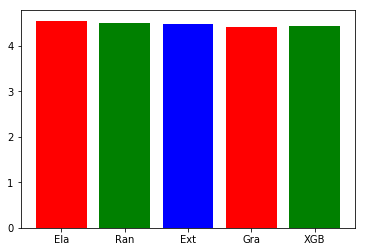

[('Ela', 4.548290636191445), ('Ran', 4.5043324365487862), ('Ext', 4.4741556509117855), ('XGB', 4.4416971687550975), ('Gra', 4.4199559638322672)]


In [30]:
trainModels(prepared_house_train,target)

In [31]:
best_reg=GradientBoostingRegressor()
best_reg.fit(prepared_house_train,target)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

## stacking

In [52]:
from sklearn.linear_model import ElasticNet
stack=StackRegressor(base_regs,ElasticNet(),0.9)
log10(sqrt(-cross_val_score(stack,prepared_house_train,target,scoring='neg_mean_squared_error',cv=5,n_jobs=-1,verbose=1).mean()))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s finished


4.4557437663903112

In [53]:
best_reg=stack
best_reg.fit(prepared_house_train,target)

C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## tuning

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid_set=[
                {'alpha':[0.01,0.1,1.]},
#                 {'C':[1.,10.,],'kernel':['rbf','poly'],'gamma':[0.01,0.1,1.],'coef0':[1.,10.,]},
                {'n_estimators':[500,1000],'max_depth':[15]},
                {'learning_rate':[0.1,],'n_estimators':[300,500],'max_depth':[3]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
                {'learning_rate':[0.1,],'n_estimators':[1000,1500,2000],'gamma':[0.0001,0.001,0.01]},
               ]

def tuneModels(train_data,target):
    results=[]
    for i in range(len(base_regs)):
        gs=GridSearchCV(estimator=base_regs[i],param_grid=param_grid_set[i],scoring='neg_mean_squared_error',n_jobs=-1,verbose=1,cv=5)
        gs.fit(train_data,target)
        results.append((gs.best_estimator_,gs.best_score_))
    print(sorted(results,key=lambda x:x[1],reverse=True))
    return results

In [43]:
help(ElasticNet)

Help on class ElasticNet in module sklearn.linear_model.coordinate_descent:

class ElasticNet(sklearn.linear_model.base.LinearModel, sklearn.base.RegressorMixin)
 |  Linear regression with combined L1 and L2 priors as regularizer.
 |  
 |  Minimizes the objective function::
 |  
 |          1 / (2 * n_samples) * ||y - Xw||^2_2
 |          + alpha * l1_ratio * ||w||_1
 |          + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
 |  
 |  If you are interested in controlling the L1 and L2 penalty
 |  separately, keep in mind that this is equivalent to::
 |  
 |          a * L1 + b * L2
 |  
 |  where::
 |  
 |          alpha = a + b and l1_ratio = a / (a + b)
 |  
 |  The parameter l1_ratio corresponds to alpha in the glmnet R package while
 |  alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio
 |  = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable,
 |  unless you supply your own sequence of alpha.
 |  
 |  Read more in the :ref:`User Guide <elastic_n

In [51]:
results=tuneModels(prepared_house_train,target)
base_regs=[r[0] for r in results]
# best_reg=results[0][0]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.6s finished
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.9s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.1s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


[(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False), -647033885.71606278), (XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0001, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1), -705684755.98466742), (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           mi

## test

In [36]:
house_test=pd.read_csv('test.csv')
test_drop_cols=list(filter(lambda c: c != target_col, drop_cols))

In [37]:
test_id=house_test[id_col]
prepared_house_test=full_pipeline.transform(house_test)
prepared_house_test.drop(test_drop_cols+list(cat_nom_cols),axis=1,inplace=True)


In [55]:
prices=best_reg.predict(prepared_house_test)
df=pd.DataFrame({id_col:test_id,target_col:prices.astype(int)})
df.to_csv('result.csv',index=False)